In [1]:
import pandas as pd
from datetime import date, timedelta
import cbpro
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

from portfolio import Portfolio

C:\Users\Artem\AppData\Local\Temp\ipykernel_24632\4038493708.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
class Asset:
    asset_dict = {}

    def __init__(self, ticker):
        self.ticker = ticker
        Asset.asset_dict[ticker] = self
        self.history = pd.DataFrame(columns = ['high', 'low', 'open', 'close', 'volume'], index = pd.Index([], name = 'date_time'))
    
    def latest_price(self):
        return self.price_on_date()
    
    def price_on_date(self, on_date = date.today):
        return self.history['close'].loc[on_date]
    
    def update_history(self, incoming_df:pd.DataFrame):
        '''
        incoming_df: the dataframe with the new historical records
        '''
        self.history = pd.concat([self.history, incoming_df]).groupby(level=0).last()


In [3]:
USD = Asset('USD')
delta = date.today() - date.fromisoformat('2000-01-01')
date_list = [date.fromisoformat('2000-01-01') + timedelta(days = i) for i in range(delta.days)]
USD_2000 = pd.DataFrame({'low':[1] * len(date_list), 'high':[1] * len(date_list),
                    'open':[1] * len(date_list), 'close':[1] * len(date_list),
                    'volume':[1000]* len(date_list)},
                     index=pd.Index(date_list, name = 'date_time'))
USD.update_history(USD_2000)

In [4]:
with open('CoinBaseAPIKey.key', 'r') as f:
    contents = f.readlines()
cb_key = contents[0].split(':')[-1].strip()
cb_secret = contents[1].split(':')[-1].strip()

In [5]:
#Download data
public_client = cbpro.PublicClient()
slots = [('2023-01-01', '2023-06-01'), ('2022-07-01', '2022-12-31'), ('2022-01-01', '2022-06-30'), ('2023-06-02', '2023-12-01')]
BTC = Asset('BTC')
ETH = Asset('ETH')
USDT = Asset('USDT')

for slot in slots:
    BTC_USD = public_client.get_product_historic_rates('BTC-USD', slot[0], slot[1], 86400)
    ETH_USD = public_client.get_product_historic_rates('ETH-USD', slot[0], slot[1], 86400)
    USDT_USD = public_client.get_product_historic_rates('USDT-USD', slot[0], slot[1], 86400)
    btc_data= pd.DataFrame(BTC_USD)
    btc_data.columns = [ 'date_time', 'low', 'high', 'open', 'close', 'volume' ]
    btc_data['date_time']= btc_data['date_time'].apply(lambda x: date.fromtimestamp(x))
    btc_data.set_index('date_time', inplace=True)
    BTC.update_history(btc_data)

    ETH_data= pd.DataFrame(ETH_USD)
    ETH_data.columns = [ 'date_time', 'low', 'high', 'open', 'close', 'volume' ]
    ETH_data['date_time']= ETH_data['date_time'].apply(lambda x: date.fromtimestamp(x))
    ETH_data.set_index('date_time', inplace=True)
    ETH.update_history(ETH_data)

    USDT_data= pd.DataFrame(USDT_USD)
    USDT_data.columns = [ 'date_time', 'low', 'high', 'open', 'close', 'volume' ]
    USDT_data['date_time']= USDT_data['date_time'].apply(lambda x: date.fromtimestamp(x))
    USDT_data.set_index('date_time', inplace=True)
    USDT.update_history(USDT_data)

C:\Users\Artem\AppData\Local\Temp\ipykernel_24632\3395490459.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.history = pd.concat([self.history, incoming_df]).groupby(level=0).last()
C:\Users\Artem\AppData\Local\Temp\ipykernel_24632\3395490459.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.history = pd.concat([self.history, incoming_df]).groupby(level=0).last()
C:\Users\Artem\AppData\Local\Temp\ipykernel_24632\3395490459.py:19: FutureWarning: The behavior of DataFrame concate

In [6]:
my_portfolio = Portfolio(origination_date=date.fromisoformat('2021-12-01'), initial_deposit=100)
my_portfolio.update_transactions(ticker='BTC', qty=1, transaction_date=date.fromisoformat('2022-01-01'))
my_portfolio.update_transactions(ticker='USDT', qty=40000, transaction_date=date.fromisoformat('2022-01-01'))
my_portfolio.update_transactions(ticker='BTC', qty=-0.5, transaction_date=date.fromisoformat('2022-01-02'))
my_portfolio.update_transactions(ticker='USDT', qty=-10000, transaction_date=date.fromisoformat('2022-01-02'))
my_portfolio.update_transactions(ticker='BTC', qty=-0.25, transaction_date=date.fromisoformat('2022-01-10'))
my_portfolio.update_transactions(ticker='USDT', qty=-20000, transaction_date=date.fromisoformat('2022-01-10'))
my_portfolio.transactions

change             note
date_time  ticker                         
2021-12-01 USD        100  Initial deposit
2022-01-01 BTC          1                 
           USDT     40000                 
2022-01-02 BTC       -0.5                 
           USDT    -10000                 
2022-01-10 BTC      -0.25                 
           USDT    -20000

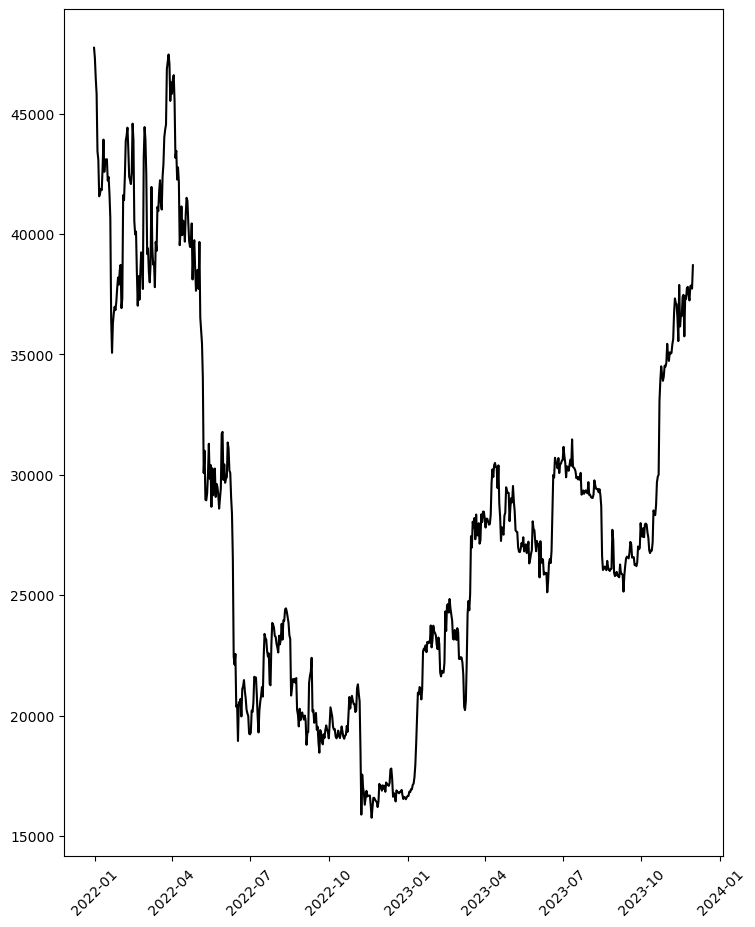

In [8]:
# Plot data we got
fig, ax = plt.subplots(1, 1, sharex = True)
fig.set_figheight(11)
fig.set_figwidth(8.5)
ax.plot(BTC.history.index, BTC.history['close'], color = 'black', label = 'Historic price')
for tick in ax.get_xticklabels():
        tick.set_rotation(45)

In [9]:
# Set up configuration objects and params
prediction_days = 15
scaler  = MinMaxScaler(feature_range=(0,1))
len_train = int(0.7*len(BTC.history))
len_test = len(BTC.history) - len_train

In [10]:
#Generate training data
x_train = []
y_train = []
scaled_data = scaler.fit_transform(np.array(BTC.history['close'].values).reshape(-1,1) )
for x in range(prediction_days, len_train):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x,0])
x_train, y_train = (np.array(x_train), np.array(y_train))
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape


(474, 15, 1)

In [11]:
# Create, compile, train the model
model = Sequential()
model.add(LSTM(units = 50, activation='tanh', return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(units = 1))
optimizer = Adam(learning_rate=0.001, name='Adam')

model.compile(optimizer = optimizer, loss = 'mse', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=20, batch_size=8)

Epoch 1/20
60/60 [==============================] - 6s 14ms/step - loss: 0.0242 - accuracy: 0.0021
Epoch 2/20
60/60 [==============================] - 1s 15ms/step - loss: 0.0085 - accuracy: 0.0021
Epoch 3/20
60/60 [==============================] - 1s 15ms/step - loss: 0.0078 - accuracy: 0.0021
Epoch 4/20
60/60 [==============================] - 1s 15ms/step - loss: 0.0096 - accuracy: 0.0021
Epoch 5/20
60/60 [==============================] - 1s 15ms/step - loss: 0.0082 - accuracy: 0.0021
Epoch 6/20
60/60 [==============================] - 1s 16ms/step - loss: 0.0084 - accuracy: 0.0021
Epoch 7/20
60/60 [==============================] - 1s 16ms/step - loss: 0.0072 - accuracy: 0.0021
Epoch 8/20
60/60 [==============================] - 1s 15ms/step - loss: 0.0069 - accuracy: 0.0021
Epoch 9/20
60/60 [==============================] - 1s 15ms/step - loss: 0.0067 - accuracy: 0.0021
Epoch 10/20
60/60 [==============================] - 1s 16ms/step - loss: 0.0055 - accuracy: 0.0021
Epoch 11/

In [12]:
input_data = BTC.history['close'].iloc[(len_train-prediction_days):]
prediction_prices = []
# Given the new data go one time point after another and make predictions 
for x in range(prediction_days, len(input_data)):
    model_input = scaler.fit_transform(np.array(input_data[x-prediction_days:x].values).reshape(-1,1) )
    model_input = np.array(model_input).reshape(1,prediction_days,1)
    prediction = model.predict(model_input,verbose = 0)
    prediction = scaler.inverse_transform(prediction)[0][0]
    print(f'Today:{input_data.iloc[x]}, predicted tomorrow: {prediction}')
    curr_date = input_data.index[x]
    current_positions = my_portfolio.get_positions(curr_date)
    BTC_value = current_positions[current_positions['ticker']=='BTC']['postion_value']
    if prediction > input_data.iloc[x]:
        my_portfolio.do_transaction(ticker='BTC', qty = 0.01 * BTC_value, transaction_date=curr_date)
    prediction_prices.append(prediction)

Today:29536.76, predicted tomorrow: 28775.103515625


KeyError: 'BTC'

In [90]:
# Make data frame for final plotting
pred_df = pd.DataFrame(prediction_prices)
pred_df.columns = ['BTC_predicted']
plot_test = pd.concat([BTC.history.iloc[len_train:].reset_index(), pred_df[['BTC_predicted']].reset_index()], axis=1)

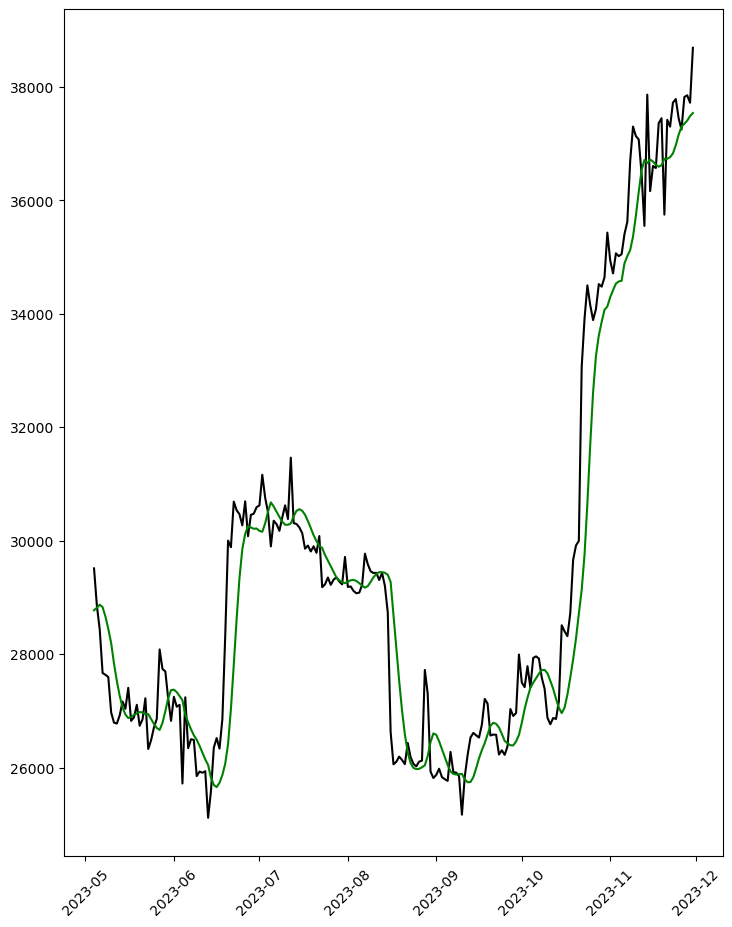

In [91]:
# Plot the results
fig, ax = plt.subplots(1, 1, sharex = True)
fig.set_figheight(11)
fig.set_figwidth(8.5)
ax.plot(plot_test['date_time'], plot_test['close'], color = 'black', label = 'Historic price')
ax.plot(plot_test['date_time'], plot_test['BTC_predicted'], color = 'green', label = 'Historic price')
for tick in ax.get_xticklabels():
        tick.set_rotation(45)